# CS4487 - Machine Learning
# Lecture 8 - Non-Linear Dimensionality Reduction, Manifold Embedding
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Non-Linear Dimensionality Reduction
    1. Kernel Principal Component Analysis (KPCA)  
2. Manifold Embedding
    1. Locally-linear embedding (LLE)
    2. Multi-dimensional Scaling (MDS)
    3. Isometric Mapping (Isomap)
    4. Spectral Embedding (Laplacian Eigenmaps)
    5. t-distributed Stochastic Neighbor Embedding (t-SNE)

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

rbow = plt.get_cmap('rainbow')

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Linear Dimensionality Reduction
- PCA, NMF, LSA are all linear dimensionality reduction methods
  - model the data as "living" on a linear manifold (line, plane, etc).
<img src="imgs/pca.png" width="800px">

# Non-linear surface
- What if the data "lives" on a non-flat surface?

In [2]:
def plot_basis(X, vo, Xp=None, sp=None, showleg=True, Y=None, showcontours=False, pca=None, showlowarrow=True):
    if sp is None:
        sp = ((1,2,1), (1,2,2))
    cols = ['k','g']
    
    if Y is None:
        Y = zeros(len(X))
        mycmap = plt.get_cmap('bwr')
    else:
        mycmap = rbow
    
    # normalize v
    v = vo.copy()
    numd = v.shape[0]
    for j in range(numd):
        v[j,:] /= linalg.norm(v[j,:])
        # flip direction if necessary
        if all(v[j,:] < 0):
            v[j,:] *= -1.0
        
    Xm = mean(X,axis=0)         # get mean
    if Xp is None:
        Xp = dot(X-Xm,v.T) # project data onto v
    
    plt.subplot(sp[0][0], sp[0][1], sp[0][2])
    # plot points
    plt.scatter(X[:,0], X[:,1], s=5, edgecolors="", c=Y, cmap=mycmap)

    plt.axis('equal'); plt.grid(True)
    plt.title('Original space (x)')
    
    tmp = plt.axis()
    hw = (tmp[1]-tmp[0])/30
    lw = hw/10
    
    mind = zeros(numd)
    maxd = zeros(numd)
    Ls = []
    LL = []
    for j in range(numd):
        mind[j] = Xp[:,j].min()
        maxd[j] = Xp[:,j].max()
        
        ofact = 0.9
        Xm2 = Xm + v[j]*maxd[j]*ofact
        Xm1 = Xm + v[j]*mind[j]*ofact
        vl = v[j]*(maxd[j]-mind[j])*ofact        

        tmp = plt.arrow(Xm1[0], Xm1[1], vl[0], vl[1], width=lw, head_width=hw, 
                        color=cols[j], length_includes_head=True)
        Ls.append(tmp)
        LL.append("PC " + str(j))

    plt.plot(Xm[0], Xm[1], 'ks')

    axbox = plt.axis()

    # plot contours
    if showcontours:
        xr = [linspace(axbox[0],axbox[1],200), 
              linspace(axbox[2],axbox[3],200)]
        xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
        allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

        Ypred = pca.transform(allpts).reshape(xgrid0.shape)
        
        L = 15
        vm = max(abs(Ypred.max()), abs(Ypred.min()))

        CS = plt.contourf(xr[0], xr[1], Ypred, L, linestyles='dashed', alpha=0.2, 
                          cmap=plt.get_cmap('bwr'), vmin=-vm, vmax=vm)
        CS = plt.contour(xr[0], xr[1], Ypred, L, linestyles='dashed', colors='k', linewidths=1)
        plt.clabel(CS, inline=1, fontsize=5)
        #plt.imshow(Ypred, origin='lower', extent=axbox, aspect='auto', a
        #        alpha=0.2, interpolation='nearest', cmap=mycmap)
    
    if showleg:
        tmp = plt.legend(Ls, LL, loc='lower right')
        tmp.get_frame().set_facecolor('white')
    
    plt.axis('normal')
    plt.axis(axbox); 
    
    plt.subplot(sp[1][0], sp[1][1], sp[1][2])
    if showlowarrow:
        plt.arrow(mind[0]*ofact, 0, (maxd[0]-mind[0])*ofact, 0, width=lw, head_width=hw, color=cols[0])
    if numd == 2:
        if showlowarrow:
            plt.arrow(0, mind[1]*ofact, 0, (maxd[1]-mind[1])*ofact, width=lw, head_width=hw, color=cols[1])        
        plt.scatter(Xp[:,0], Xp[:,1], s=10, marker='+', c=Y, cmap=mycmap)
        plt.xlabel('w1')
        plt.ylabel('w2')
    else:
        plt.scatter(Xp[:,0], zeros(len(Xp)), s=15, marker='+', c=Y, cmap=mycmap)
        plt.xlabel('w')

    plt.axis('equal'); plt.grid(True)
    plt.title('Low-dim space (w)')

In [3]:
random.seed(5230)

# polynomial manifold
tX = random.uniform(-6,6,size=(200,1))
#tY = 0.1*(tX-1)*(tX+5)*(tX-5)
tY = 0.2*tX**2
tY += random.normal(scale=0.5, size=(200,1))
Xpoly = c_[tX, tY]
Ypoly = tX

pfig = plt.figure()
plt.scatter(Xpoly[:,0], Xpoly[:,1], s=5, edgecolor="")
plt.axis('equal')
plt.grid(True)
plt.close()
X = Xpoly
Y = Ypoly.ravel()

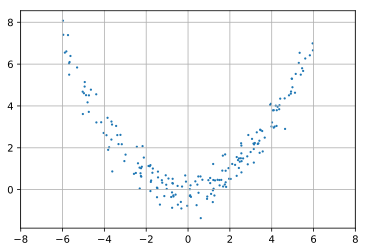

In [4]:
pfig

- PCA can't capture the curvature of the data
  - purple points are close together
  - red points are close together

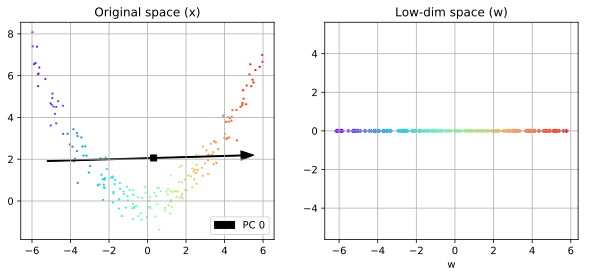

In [5]:
pca = decomposition.PCA(n_components=1)
W   = pca.fit_transform(X)

plt.figure(figsize=(10,4))
plot_basis(X, pca.components_, Y=Y, showlowarrow=False)

- iso-contours of PCA projection
  - points on the same dashed line are projected to the same PCA coefficient.

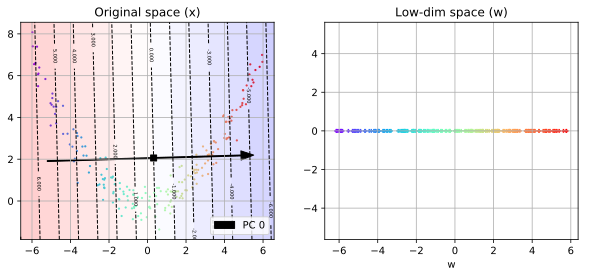

In [6]:
plt.figure(figsize=(10,4))
plot_basis(X, pca.components_, Y=Y, showcontours=True, pca=pca, showlowarrow=False)

# Kernel PCA
- _How to project to a non-linear surface?_
  - apply a high-dimensional feature transformation to the data
    - $\mathbf{x}_i \Rightarrow \phi(\mathbf{x}_i)$
  - project high-dim data to a linear surface
    - i.e. run PCA on $\phi(\mathbf{x}_i)$
  - in the original space, the projection will be non-linear
<img src="imgs/kpca.png" width=600>

# Kernel principal components
- kernel principal component $\mathbf{v}$ is a linear combination of high-dim vectors
  - $\mathbf{v} = \sum_{i=1}^n \alpha_i \phi(\mathbf{x}_i)$
  - where $\alpha_i$ are learned weights.
- For a new point $\mathbf{x}_*$, the KPCA coefficient for $\mathbf{v}$ is
  - $w = \phi(\mathbf{x}_*)^T\mathbf{v} = \sum_{i=1}^n \alpha_i\phi(\mathbf{x}_*)^T \phi(\mathbf{x}_i) = \sum_{i=1}^n \alpha_i k(\mathbf{x}_*, \mathbf{x}_i)$
  - coefficient is based on similarity to data points belonging to $\mathbf{v}$.
  - using the kernel trick saves computation.


In [7]:
def plot_kpca(X, W, kpca, showleg=True, Y=None, showcontours=False, showpcs=None, colorcoefs=False):
    cols = ['k','g']
    
    numd = W.shape[1]
    
        
    if Y is None:
        Y = zeros(len(X))
        mycmap = plt.get_cmap('bwr')
    else:
        mycmap = rbow
        
    if showpcs is None:
        showpcs = range(numd)

    if len(showpcs)==1:
        sx=2; sy=1
    elif len(showpcs)==2:
        sx=2; sy=2
    else:
        sx=2; sy=ceil(len(showpcs)/2.)
        
    for i,d in enumerate(showpcs):        
        plt.subplot(sy, sx, i+1)
        # plot points
        if colorcoefs:
            myec = 'k'
            myc = W[:,d]
        else:
            myc = Y
            myec = ''
            
        plt.scatter(X[:,0], X[:,1], s=7, edgecolor=myec, c=myc, cmap=mycmap)
        
        plt.axis('equal'); plt.grid(True)
        plt.title('Original space (x) : PC ' + str(d+1))

        #tmp = plt.axis()
        #hw = (tmp[1]-tmp[0])/30
        #lw = hw/10

        # plot contours
        if showcontours:
            if i==0:
                axbox = plt.axis()
                xr = [linspace(axbox[0],axbox[1],200), 
                      linspace(axbox[2],axbox[3],200)]
                xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
                allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
                Wpred = kpca.transform(allpts)
            
            L = 15
            if numd>1:
                tmpW = Wpred[:,d].reshape(xgrid0.shape)
            else:
                tmpW = Wpred.reshape(xgrid0.shape)

            vm = max(abs(tmpW.max()), abs(tmpW.min()))

            CS = plt.contourf(xr[0], xr[1], tmpW, L, linestyles='dashed', alpha=0.2, 
                              cmap=plt.get_cmap('bwr'), vmin=-vm, vmax=vm)
            CS = plt.contour(xr[0], xr[1], tmpW, L, linestyles='dashed', colors='k', linewidths=0.5)
            plt.axis('normal'); plt.axis(axbox)

        
    if (numd<=2):
        plt.subplot(sy, sx, i+2)
        #plt.arrow(mind[0]*ofact, 0, (maxd[0]-mind[0])*ofact, 0, width=lw, head_width=hw, color=cols[0])
        if numd == 2:
            #plt.arrow(0, mind[1]*ofact, 0, (maxd[1]-mind[1])*ofact, width=lw, head_width=hw, color=cols[1])        
            plt.scatter(W[:,0], W[:,1], s=10, marker='+', c=Y, cmap=mycmap)
            plt.xlabel('w1')
            plt.ylabel('w2')
        else:
            plt.scatter(W[:,0], zeros(len(W)), s=15, marker='+', c=Y, cmap=mycmap)
            plt.xlabel('w')

        plt.axis('equal'); plt.grid(True)
        plt.title('Low-dim space (w)')

- Example using polynomial kernel
  - purple points are further apart.
  - PC coefficient corresponds to location along the data curve.

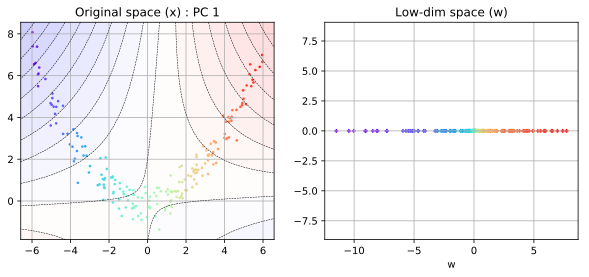

In [8]:
# run KPCA
kpca = decomposition.KernelPCA(n_components=1, kernel='poly', gamma=0.15, degree=2, coef0=0)
W = kpca.fit_transform(X)

plt.figure(figsize=(10,4))
plot_kpca(X, W, kpca, showcontours=True, Y=Y)

- Example: 2 PCs
  - 2nd PC corresponds to the distance from the center

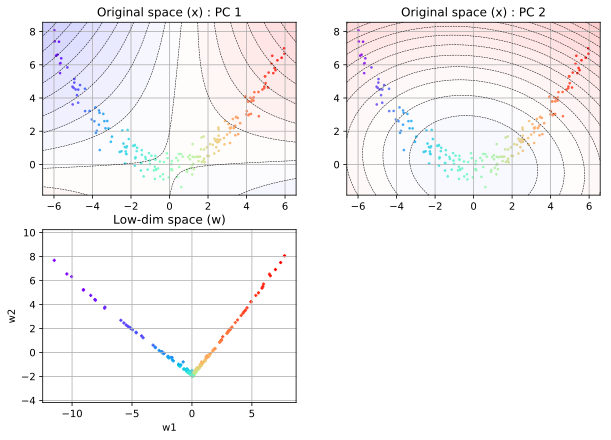

In [9]:
# run KPCA
kpca = decomposition.KernelPCA(n_components=2, kernel='poly', gamma=0.15, degree=2, coef0=0)
W = kpca.fit_transform(X)

plt.figure(figsize=(10,7))
plot_kpca(X, W, kpca, showcontours=True, Y=Y)

# RBF kernel
- principal components separate the data into clusters
- coefficient is distance to clusters

In [10]:
[Xblobs, Yblobs] = datasets.make_blobs(n_samples=200, n_features=2, cluster_std=1.0, 
                             centers=[[0,5],[-5,-5],[5,-3]], random_state=1234)
X = Xblobs
Y = Yblobs

# Example
- data with 3 clusters

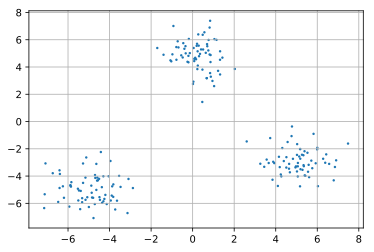

In [11]:
plt.scatter(X[:,0], X[:,1], s=6, edgecolor="")
plt.grid(True);

- The first 2 PCs can split the data into 3 clusters
  - the color of the datapoint corresponds to the coefficient value.

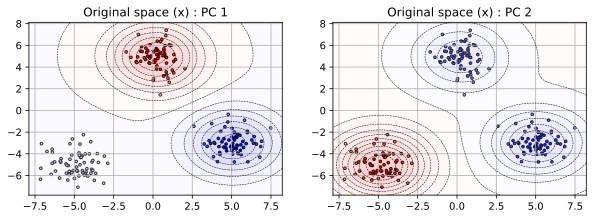

In [12]:
# run KPCA
kpca = decomposition.KernelPCA(n_components=8, kernel='rbf', gamma=0.15)
W = kpca.fit_transform(X)

plt.figure(figsize=(10,7))
plot_kpca(X, W, kpca, showcontours=True, showpcs=[0,1], colorcoefs=True)

- The remaining 6 PCs split each cluster into halves
  - multiple splits in orthogonal directions

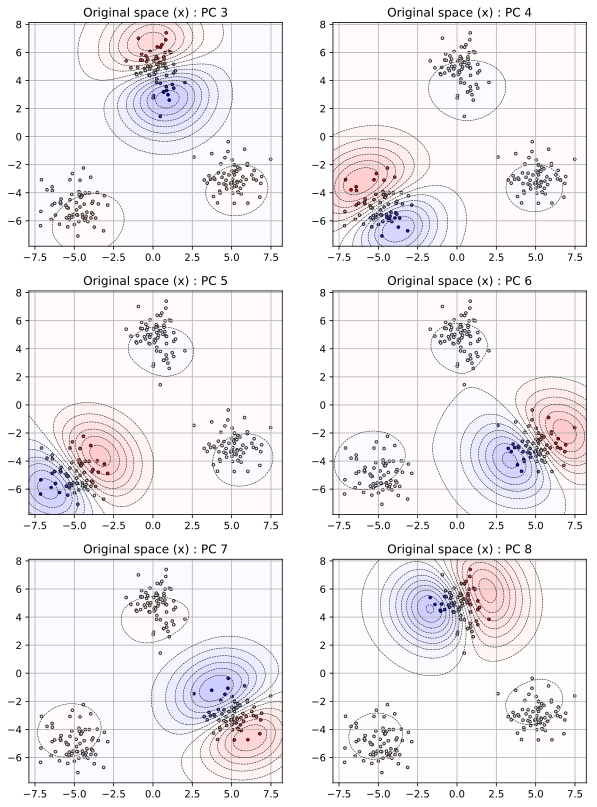

In [13]:
plt.figure(figsize=(10,14))
plot_kpca(X, W, kpca, showcontours=True, showpcs=range(2,8), colorcoefs=True)

# Example on digit images
- 8 x 8 images -> 64D vector

In [14]:
digits = datasets.load_digits(n_class=10)
X = digits.data
Y = digits.target

# randomly split data into training and testing
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.8, test_size=0.2, random_state=4487)

In [15]:
img = digits.images;
tmp = []
for i in range(0,200,20):
    tmp.append( hstack(img[i:i+20]) )
    tmp.append( zeros((2,8*20)) )
allimg = vstack(tmp)
digitfig = plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.close()

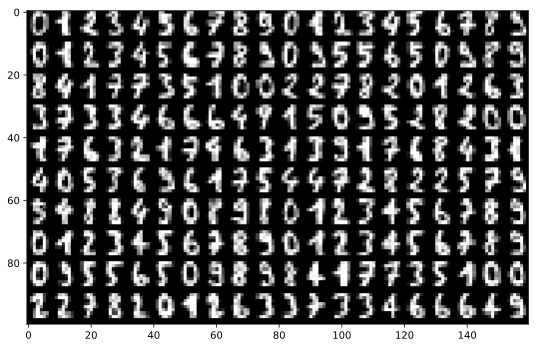

In [16]:
digitfig

- Apply KPCA with RBF kernel
  - (parallelize with `n_jobs`)

In [17]:
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001, n_jobs=-1)
trainW = kpca.fit_transform(trainX)

In [18]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj],), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

- Top-5 positive and negative prototypes for each PC
  - the number is the $\alpha$ value for that image.
  - from the prototypes, the PCs are modeling the differences in appearance between digits

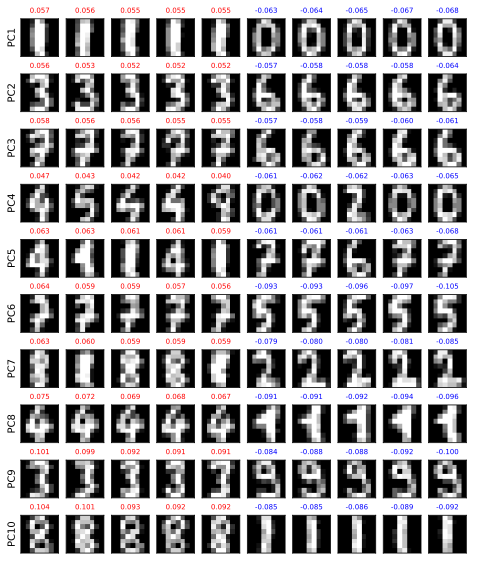

In [19]:
plt.figure(figsize=(8,10))
plot_kbasis(kpca, (8,8), trainX)

# Classification experiment
- use KPCA coefficients as the new representation
  - train a logistic regression classifier
  - try different numbers of components
    - Note: can do this efficiently by selecting a subset of KPCA components.

In [20]:
# apply kernel PCA
kpca = decomposition.KernelPCA(n_components=60, kernel='rbf', gamma=0.001, n_jobs=-1)
trainW = kpca.fit_transform(trainX)
testW = kpca.transform(testX)

In [21]:
ncs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
accs = []
for nc in ncs: 
    # extract the first nc PCs
    trainWnew = trainW[:,0:nc]
    testWnew  = testW[:,0:nc]
    
    # train classifier
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5, n_jobs=-1)
    logreg.fit(trainWnew, trainY)

    # test classifier
    predYtest  = logreg.predict(testWnew)
    acc        = metrics.accuracy_score(testY, predYtest)
    accs.append(acc)

In [22]:
# baseline linear classifier on raw image
logreg2 = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5, n_jobs=-1)
logreg2.fit(trainX, trainY)
predYtest  = logreg2.predict(testX)
acc_raw    = metrics.accuracy_score(testY, predYtest)

In [23]:
# baseline linear classifier using PCA
pca = decomposition.PCA(n_components=60)
trainW = pca.fit_transform(trainX)
testW  = pca.transform(testX)

accs_pca = []
for nc in ncs: 
    # extract the first nc PCs
    trainWnew = trainW[:,0:nc]
    testWnew  = testW[:,0:nc]
    
    # train classifier
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5, n_jobs=-1)
    logreg.fit(trainWnew, trainY)

    # test classifier
    predYtest  = logreg.predict(testWnew)
    acc        = metrics.accuracy_score(testY, predYtest)
    accs_pca.append(acc)

- Classification results on test set
  - KPCA can improve the performance, compared with PCA and raw image.

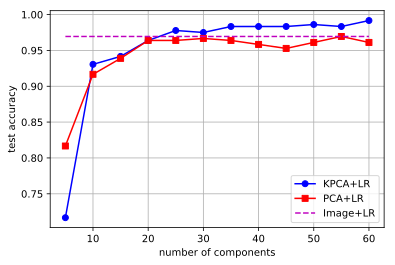

In [24]:
# make a plot
plt.plot(ncs, accs, 'bo-', label='KPCA+LR')
plt.plot(ncs, accs_pca, 'rs-', label='PCA+LR')
plt.plot([min(ncs), max(ncs)], [acc_raw, acc_raw], 'm--', label='Image+LR')
plt.legend(loc="best")
plt.xlabel('number of components')
plt.ylabel('test accuracy')
plt.grid(True)

# KPCA Summary
- Use kernel trick to perform PCA in high-dimensional space.
  - Coefficients are based on a non-linear projection of the data.
  - The type of projection is based on the kernel function selected.
- Using RBF kernel, KPCA can split the data into clusters.